t-SNE using only numerical data, leaving out the three outcomes of interest

In [ ]:
# setup
from google.colab import drive
drive.mount('/content/drive')

# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

Mounted at /content/drive


In [ ]:
# import data
path = '/content/drive/MyDrive/fall2025/csci5526/CSCI 5526 Project/clean_dataset.csv' # Kenna

df = pd.read_csv(path)
print("Original shape:", df.shape)

#converting the time columns to real datetimes (needed for ICU readmission label)
for col in ["ADMITTIME", "DISCHTIME", "INTIME", "OUTTIME"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")


#for different models:
#a) 30-day readmission-- READMIT_30D already computed in prep.ipynb
#b) Mortality
#use HOSPITAL_EXPIRE_FLAG (0 = survived, 1 = died in hospital)
if "HOSPITAL_EXPIRE_FLAG" in df.columns:
    df["HOSPITAL_EXPIRE_FLAG"] = df["HOSPITAL_EXPIRE_FLAG"].fillna(0).astype(int)
#c) ICU readmission within 30 days
#next ICU admission for the same SUBJECT_ID starting within 30 days (720 hours) after current ICU OUTTIME.
if {"SUBJECT_ID", "INTIME", "OUTTIME"}.issubset(df.columns):
    df = df.sort_values(["SUBJECT_ID", "INTIME"])
    df["NEXT_ICU_INTIME"] = df.groupby("SUBJECT_ID")["INTIME"].shift(-1)

    df["HOURS_TO_NEXT_ICU"] = (
        (df["NEXT_ICU_INTIME"] - df["OUTTIME"]).dt.total_seconds() / 3600
    )

    df["ICU_READMIT_30D"] = (df["HOURS_TO_NEXT_ICU"] <= 720).astype(float)
    df["ICU_READMIT_30D"] = df["ICU_READMIT_30D"].fillna(0).astype(int)
else:
    print("Warning: cannot create ICU_READMIT_30D (missing SUBJECT_ID/INTIME/OUTTIME).")


#dropping columns
cols_to_drop = [
    # unneeded identifiers
    "ROW_ID_x", "ROW_ID_y", "ROW_ID",
    "SUBJECT_ID", "HADM_ID", "ICUSTAY_ID",

    # unused time columns (we already used them for labels)
    "ADMITTIME", "DISCHTIME", "DEATHTIME",
    "EDREGTIME", "EDOUTTIME", "INTIME", "OUTTIME",
    "DOB", "DOD", "DOD_HOSP", "DOD_SSN",

    # label construction helpers (would leak information)
    "NEXT_ADMITTIME", "HOURS_TO_NEXT",
    "NEXT_ICU_INTIME", "HOURS_TO_NEXT_ICU",

    # extra mortality-related flag that can leak label info
    "EXPIRE_FLAG",
]

df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

print("After dropping ID / time / helper cols:", df.shape)

#dropping columns with >80% NaN
nan_threshold = 0.8
df = df.dropna(axis=1, thresh=len(df) * (1 - nan_threshold))
print("After dropping mostly-NaN columns:", df.shape)

#make sure our three targets still exist
label_cols = ["READMIT_30D", "HOSPITAL_EXPIRE_FLAG", "ICU_READMIT_30D"]
label_cols = [c for c in label_cols if c in df.columns]
print("Available targets:", label_cols)

Original shape: (62722, 101)
After dropping ID / time / helper cols: (62722, 82)
After dropping mostly-NaN columns: (62722, 82)
Available targets: ['READMIT_30D', 'HOSPITAL_EXPIRE_FLAG', 'ICU_READMIT_30D']


In [ ]:
# setup data for t-SNE
#don't allow any of the label (target) columns to be features
labels_present = [c for c in label_cols if c in df.columns]
feature_df = df.drop(columns=labels_present)

y = df[label_cols]
X = feature_df.copy()

#keep only numeric features + the small set of allowed categoricals
#categorical_cols = [c for c in allowed_categoricals if c in X.columns]
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

#X = X[numeric_cols + categorical_cols].copy() # if also using categorical columns
X = X[numeric_cols].copy()

# scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# t-SNE model
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)


In [ ]:
labels_present

['READMIT_30D', 'HOSPITAL_EXPIRE_FLAG', 'ICU_READMIT_30D']

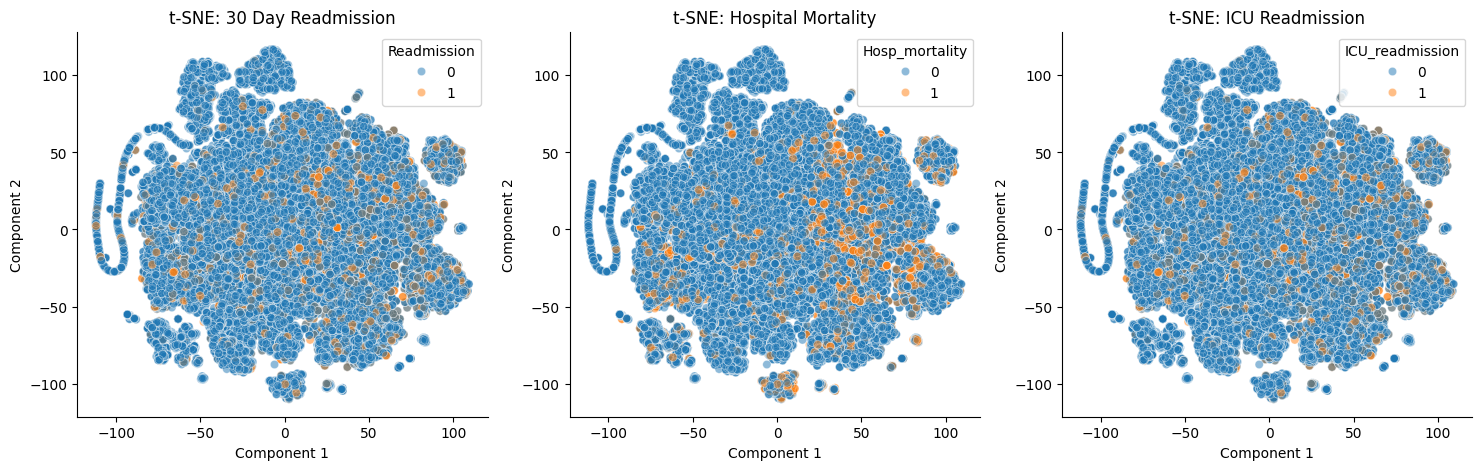

In [ ]:
import seaborn as sns

# plot 2D t-SNE
plt.figure(figsize=(18,5))

# data frame
df_tsne = pd.DataFrame(X_tsne, columns=['Component 1', 'Component 2'])
df_tsne['Readmission'] = y['READMIT_30D']
df_tsne['Hosp_mortality'] = y['HOSPITAL_EXPIRE_FLAG']
df_tsne['ICU_readmission'] = y['ICU_READMIT_30D']

# readmission
plt.subplot(1,3,1)
sns.scatterplot(data=df_tsne, x='Component 1', y='Component 2', hue='Readmission', alpha=0.5)
plt.title("t-SNE: 30 Day Readmission")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
sns.despine()

# Died in hospital
plt.subplot(1,3,2)
sns.scatterplot(data=df_tsne, x='Component 1', y='Component 2', hue='Hosp_mortality', alpha=0.5)
plt.title("t-SNE: Hospital Mortality")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
sns.despine()

# ICU readmission
plt.subplot(1,3,3)
sns.scatterplot(data=df_tsne, x='Component 1', y='Component 2', hue='ICU_readmission', alpha=0.5)
plt.title("t-SNE: ICU Readmission")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
sns.despine()


t-SNE components do not appear well-separated for any class. Hospital mortality has slightly better separation than readmission.

In [ ]:
# plot just a random sample of the points to make sure there are no distinct clusters

# TBD

# TBD

# TBD

In [ ]:
# 3D t-SNE
# t-SNE model
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

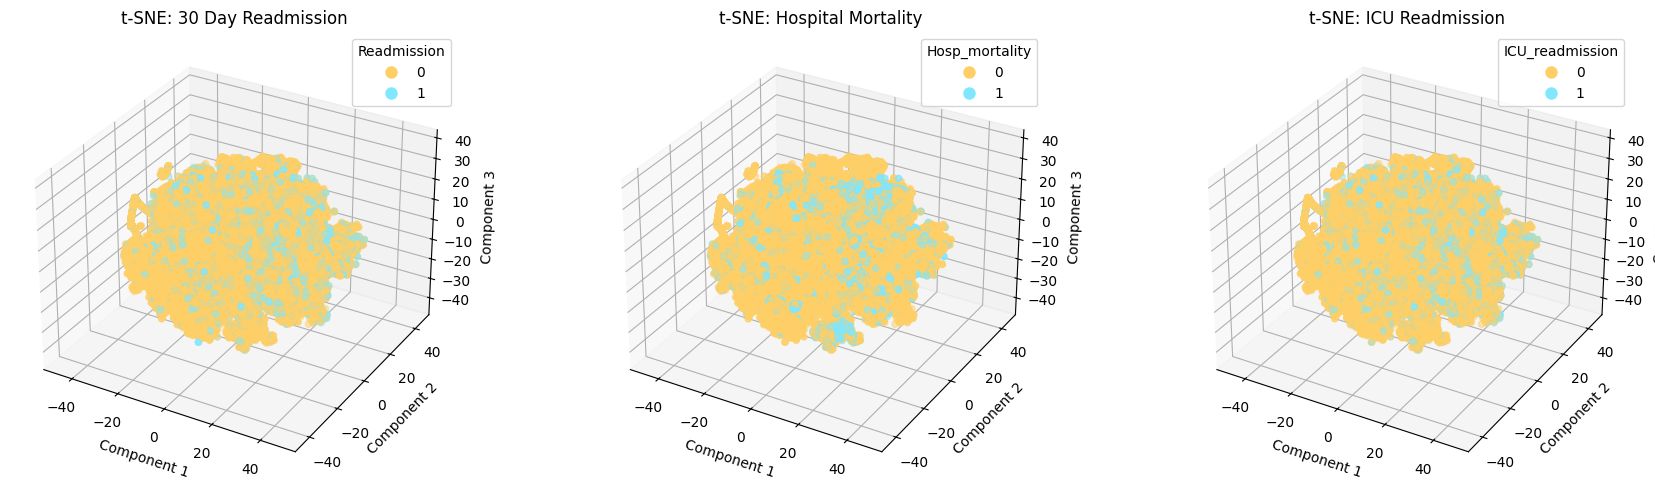

In [ ]:
import matplotlib.pyplot as plt

# plot 3D t-SNE
fig = plt.figure(figsize=(18,5))

# data frame
df_3dtsne = pd.DataFrame(X_tsne, columns=['Component 1', 'Component 2', 'Component 3'])
df_3dtsne['Readmission'] = y['READMIT_30D']
df_3dtsne['Hosp_mortality'] = y['HOSPITAL_EXPIRE_FLAG']
df_3dtsne['ICU_readmission'] = y['ICU_READMIT_30D']

# colormap
cmap = plt.colormaps['managua']

# Helper function to create robust legend handles
def create_legend_handles(outcome_series, cmap):
    legend_handles = []
    unique_labels = sorted(outcome_series.unique())

    # Determine min/max for normalization if there's a range
    if len(unique_labels) > 1:
        min_label = unique_labels[0]
        max_label = unique_labels[-1]
        norm_range = max_label - min_label
    else:
        # If only one unique label (e.g., all 0s), treat range as 1 for normalization
        min_label = 0
        max_label = 0
        norm_range = 1 # Ensures normalized_label_val becomes 0 for cmap(0)

    for label_val in unique_labels:
        if norm_range == 0: # This implies only one label, which must be 0 or 1. Map to 0 or 1 respectively
            normalized_label_val = label_val # If range is 0, the single label determines the color
        else:
            normalized_label_val = (label_val - min_label) / norm_range

        legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=str(int(label_val)),
                                  markerfacecolor=cmap(normalized_label_val), markersize=10))
    return legend_handles

# 30 day readmission
ax1 = fig.add_subplot(1,3,1, projection='3d')
scatter1 = ax1.scatter(df_3dtsne['Component 1'], df_3dtsne['Component 2'], df_3dtsne['Component 3'],
                       c=df_3dtsne['Readmission'].values, cmap=cmap, alpha=0.5)
ax1.set_title("t-SNE: 30 Day Readmission")
ax1.set_xlabel("Component 1")
ax1.set_ylabel("Component 2")
ax1.set_zlabel("Component 3")
ax1.legend(handles=create_legend_handles(df_3dtsne['Readmission'], cmap), title="Readmission")

# mortality
ax2 = fig.add_subplot(1,3,2, projection='3d')
scatter2 = ax2.scatter(df_3dtsne['Component 1'], df_3dtsne['Component 2'], df_3dtsne['Component 3'],
                       c=df_3dtsne['Hosp_mortality'].values, cmap=cmap, alpha=0.5)
ax2.set_title('t-SNE: Hospital Mortality')
ax2.set_xlabel("Component 1")
ax2.set_ylabel("Component 2")
ax2.set_zlabel("Component 3")
ax2.legend(handles=create_legend_handles(df_3dtsne['Hosp_mortality'], cmap), title="Hosp_mortality")

# ICU readmission
ax3 = fig.add_subplot(1,3,3, projection='3d')
scatter3 = ax3.scatter(df_3dtsne['Component 1'], df_3dtsne['Component 2'], df_3dtsne['Component 3'],
                       c=df_3dtsne['ICU_readmission'].values, cmap=cmap, alpha=0.5)
ax3.set_title('t-SNE: ICU Readmission')
ax3.set_xlabel("Component 1")
ax3.set_ylabel("Component 2")
ax3.set_zlabel("Component 3")
ax3.legend(handles=create_legend_handles(df_3dtsne['ICU_readmission'], cmap), title="ICU_readmission")

plt.tight_layout()
plt.show()